# Train RetinaNet model on CMCT-MEL data set

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.sampling import get_slides
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet

path = Path('databases/')

database = Database()
database.open(str(path/'MITOS_WSI_CCMCT_MEL.sqlite'))

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


## Split dataset into train/validation and test on slide level

In [2]:
getslides = """SELECT filename FROM Slides"""
all_slides = database.execute(getslides).fetchall()


Convert database into in-memory object

In [3]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, database=database, negative_class=4)
            

Loading slides .. : 100%|██████████| 32/32 [00:11<00:00,  3.44it/s]


In [4]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [5]:
bs = 16
train_images = 5000
val_images = 5000
size=256

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))


train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

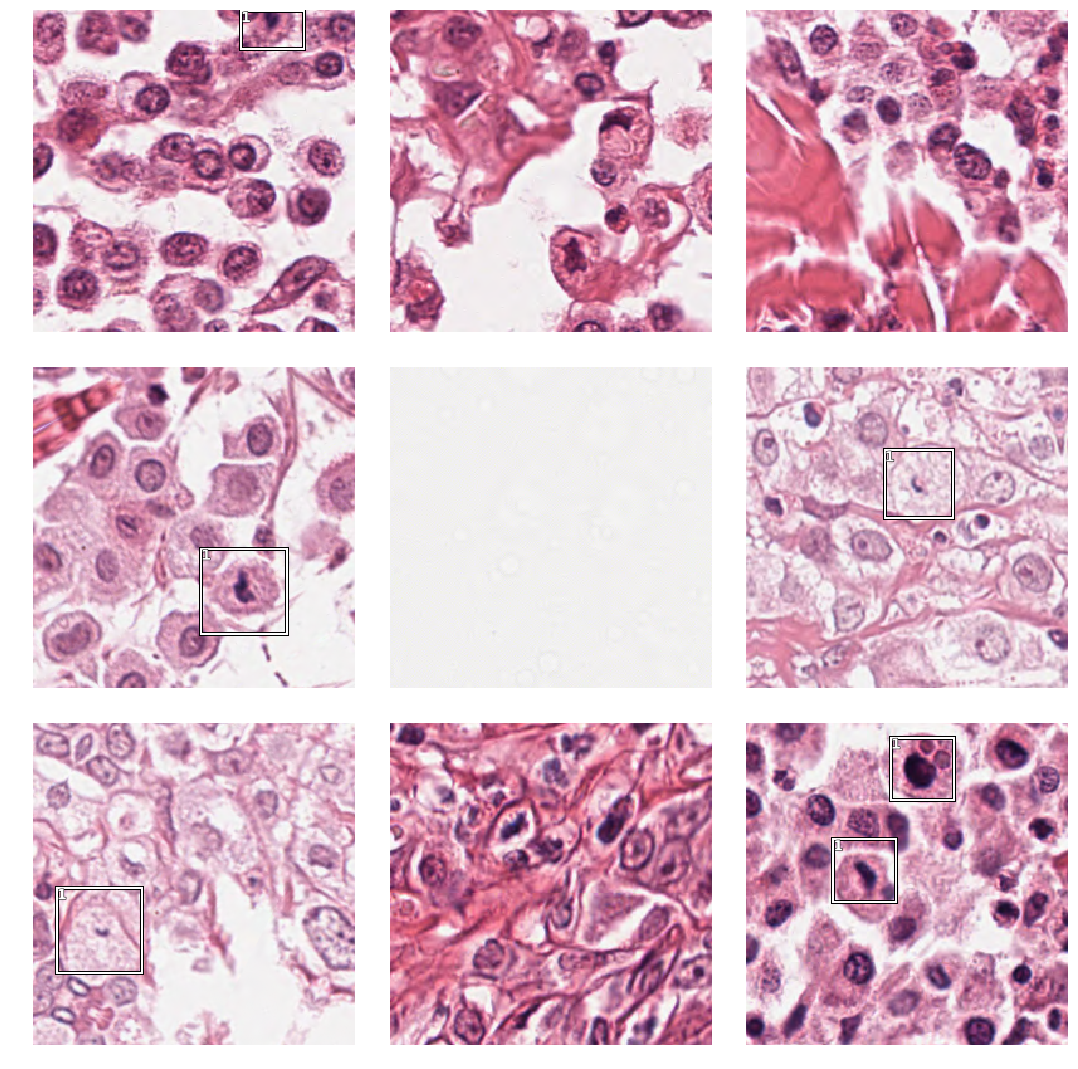

In [6]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

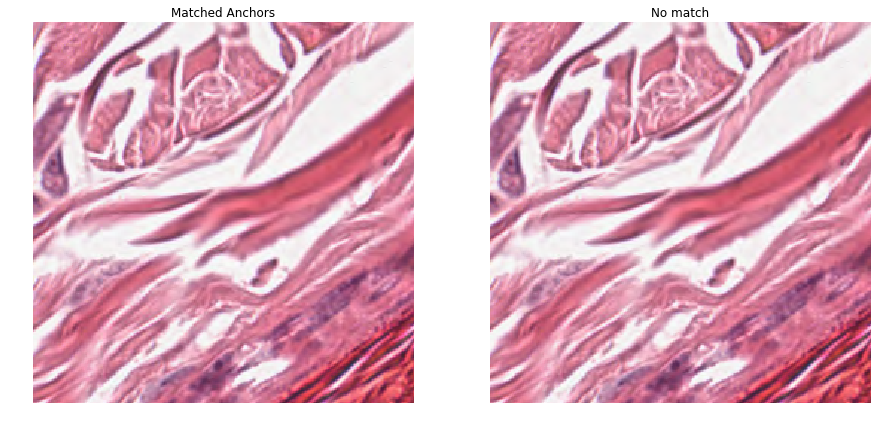

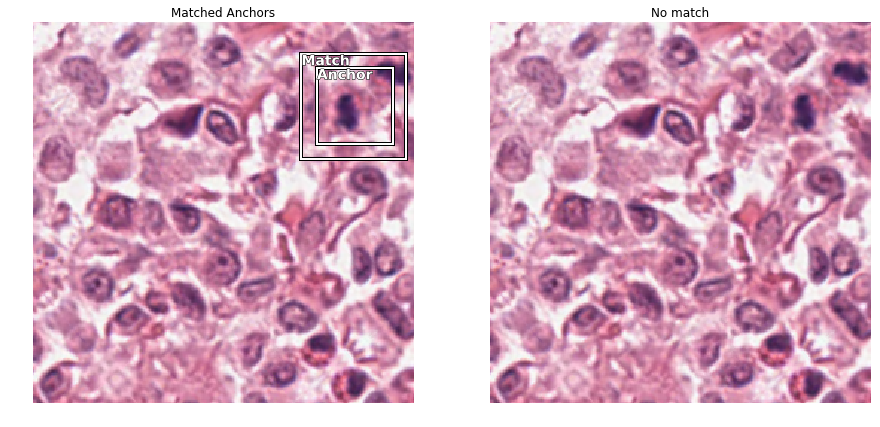

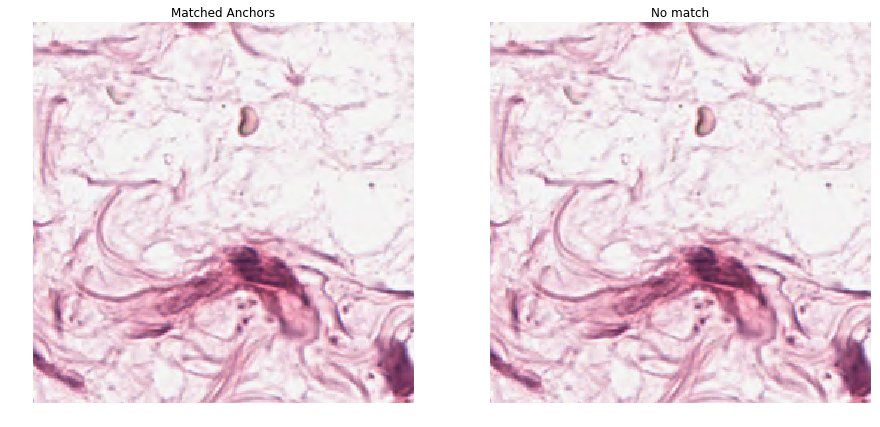

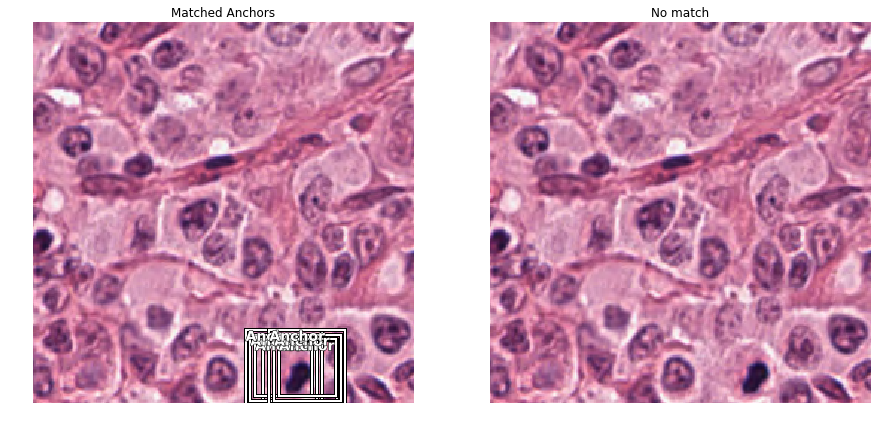

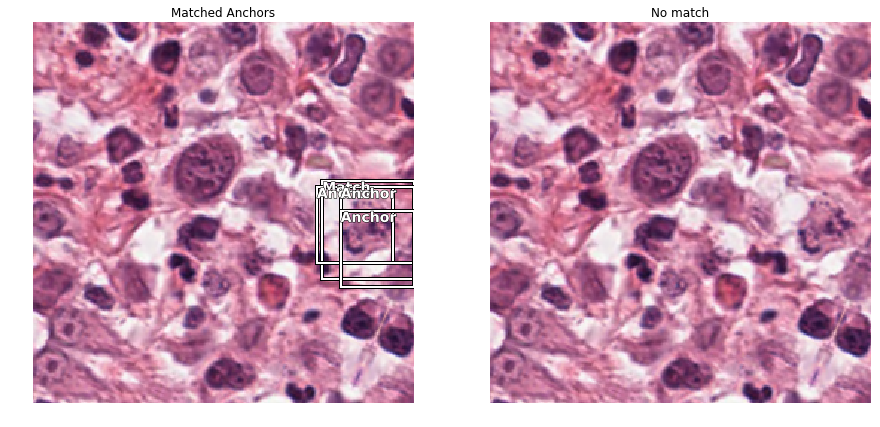

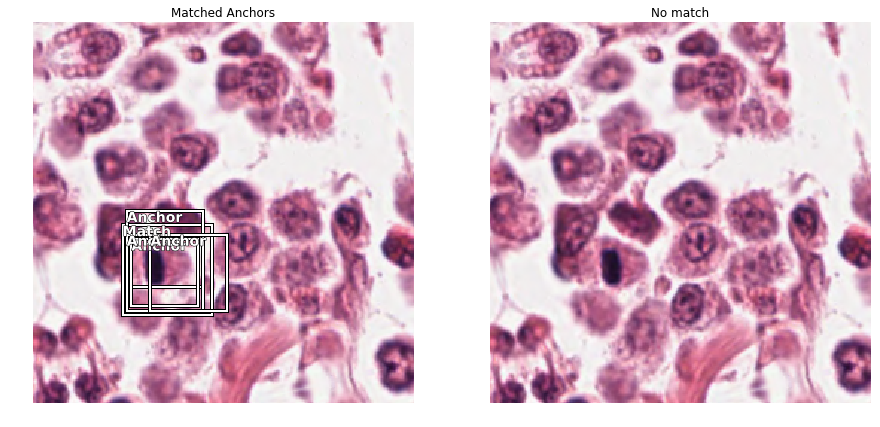

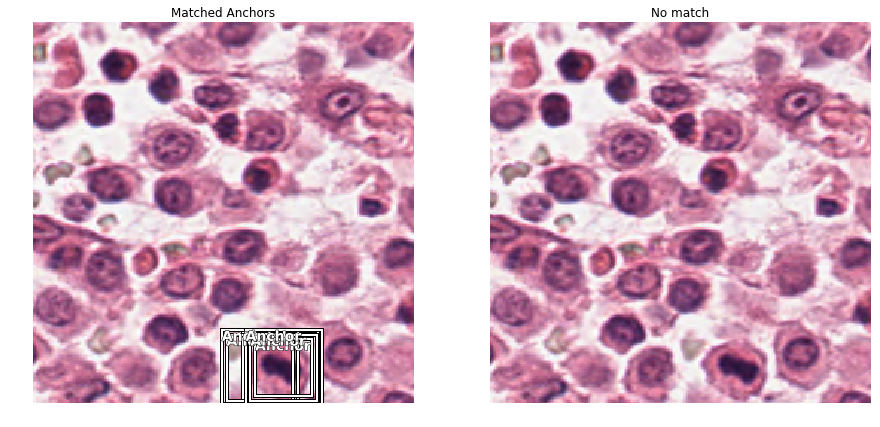

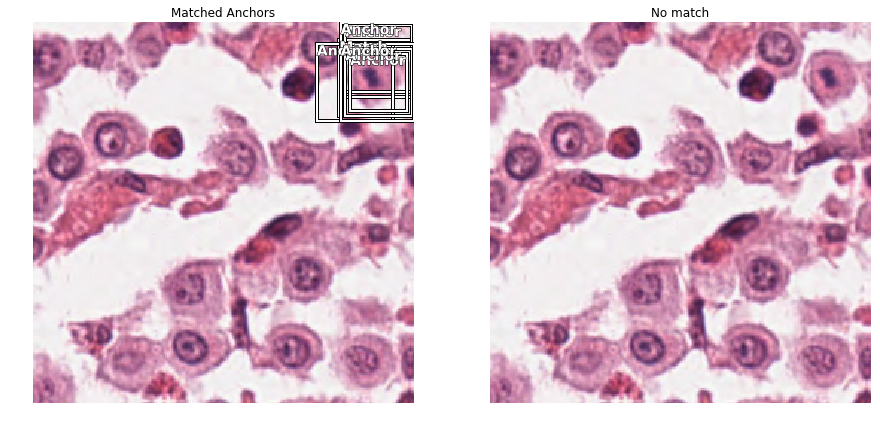

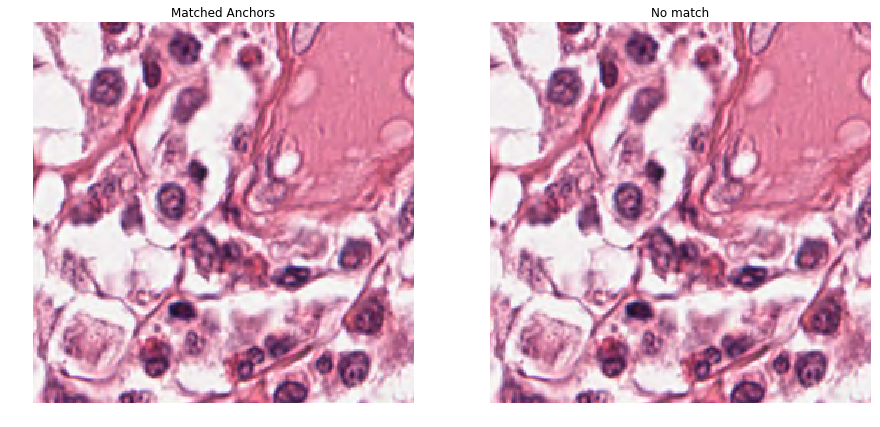

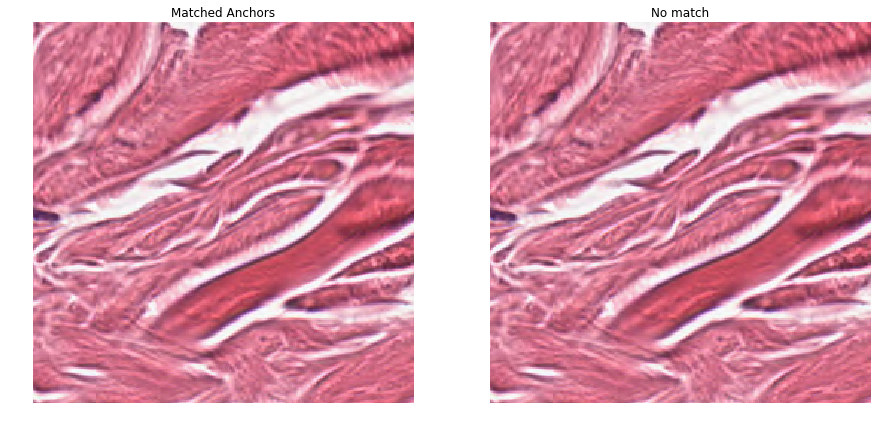

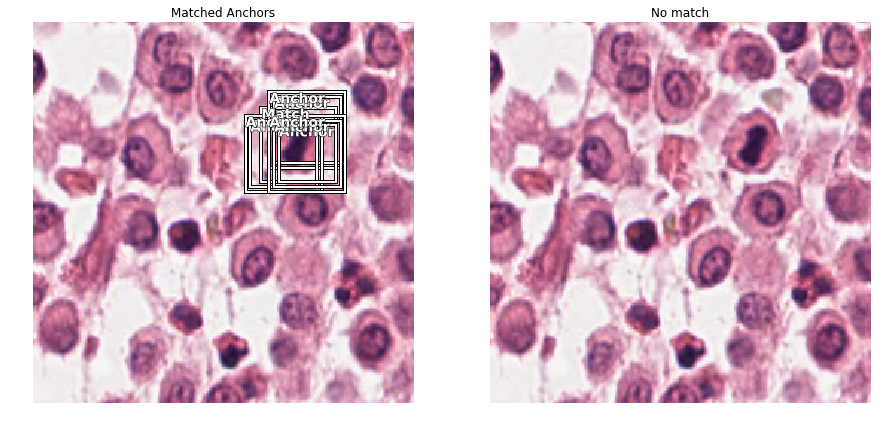

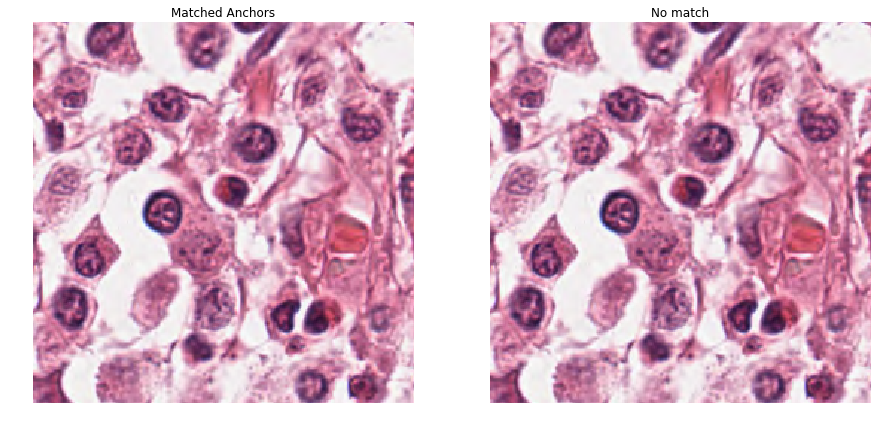

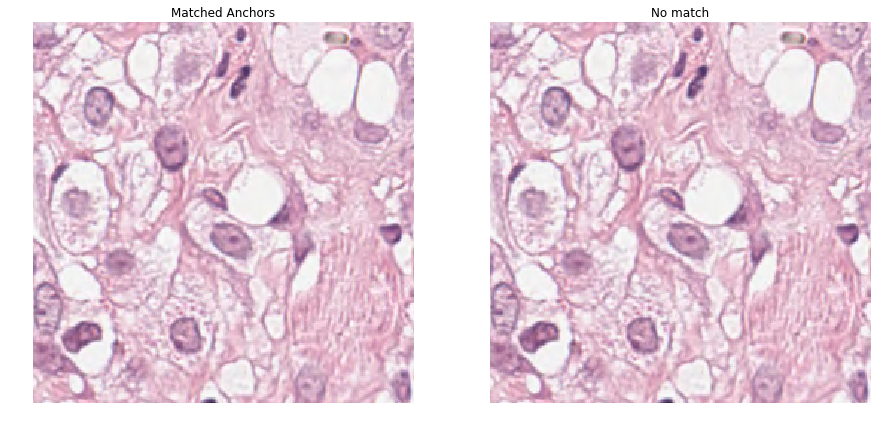

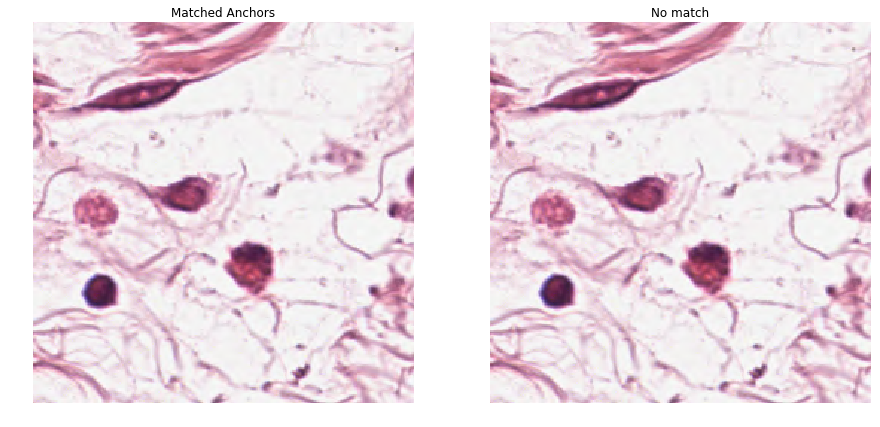

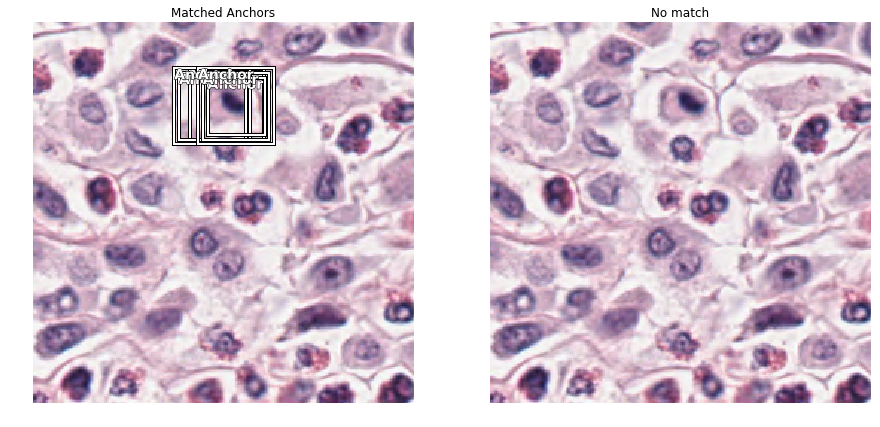

In [7]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])
not_found = show_anchors_on_images(data, anchors)

In [8]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [9]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [10]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


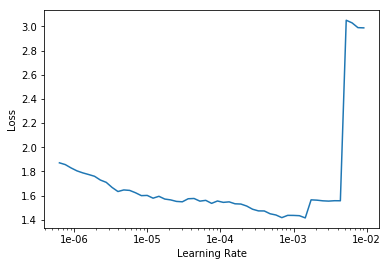

In [11]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 1744/1744 [00:00<00:00, 5655.43it/s]


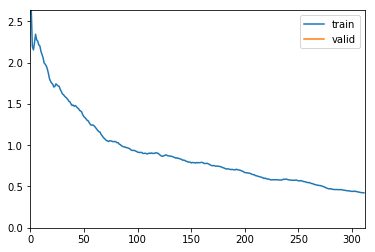

In [12]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|██████████| 1775/1775 [00:00<00:00, 4511.55it/s]


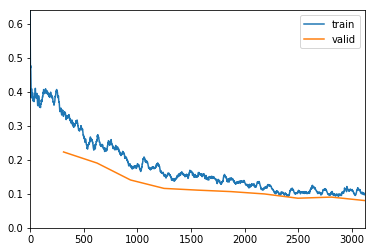

GT: 100%|██████████| 1749/1749 [00:00<00:00, 5859.35it/s]


In [13]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

GT: 100%|██████████| 1821/1821 [00:00<00:00, 5531.12it/s]


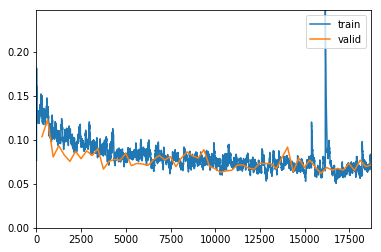

Better model found at epoch 0 with pascal_voc_metric value: 0.781083924372959.


GT: 100%|██████████| 1831/1831 [00:00<00:00, 6016.32it/s]


Better model found at epoch 1 with pascal_voc_metric value: 0.8423745609089596.


GT: 100%|██████████| 1829/1829 [00:00<00:00, 4785.39it/s]


Better model found at epoch 8 with pascal_voc_metric value: 0.8573546287086632.


GT: 100%|██████████| 1832/1832 [00:00<00:00, 5775.93it/s]


Better model found at epoch 18 with pascal_voc_metric value: 0.8616526931223063.


GT: 100%|██████████| 1807/1807 [00:00<00:00, 5707.48it/s]


Better model found at epoch 19 with pascal_voc_metric value: 0.8698459209754484.


GT: 100%|██████████| 1844/1844 [00:00<00:00, 6037.67it/s]


Better model found at epoch 42 with pascal_voc_metric value: 0.8837105814443467.


GT: 100%|██████████| 1881/1881 [00:00<00:00, 5774.79it/s]


In [14]:
learn.unfreeze()
lr=1e-4

learn.fit(60, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

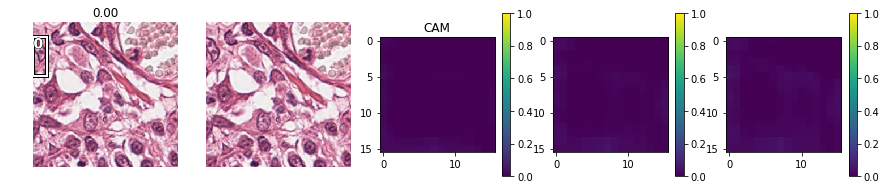

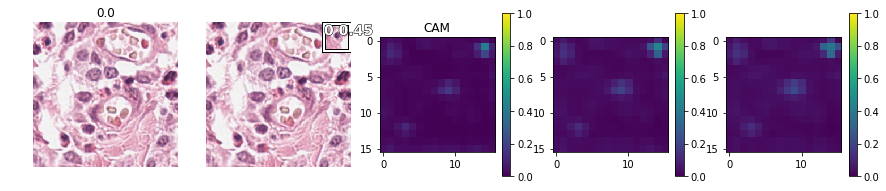

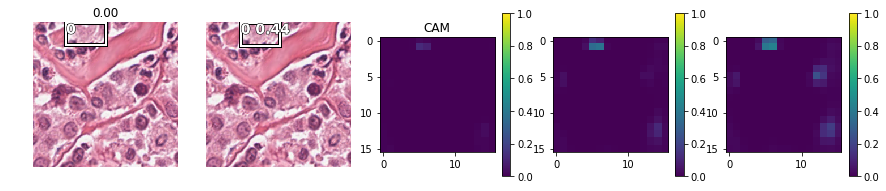

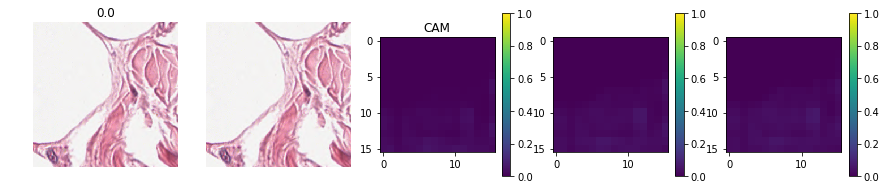

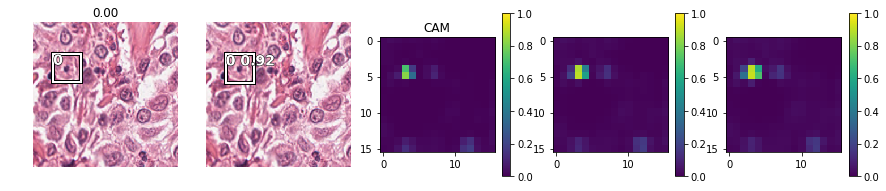

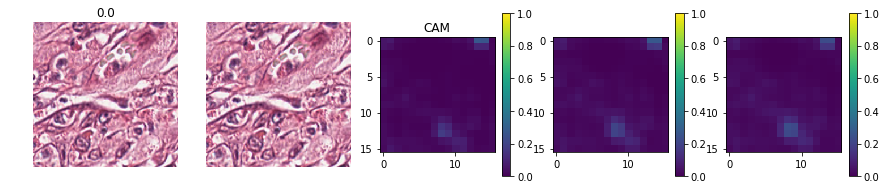

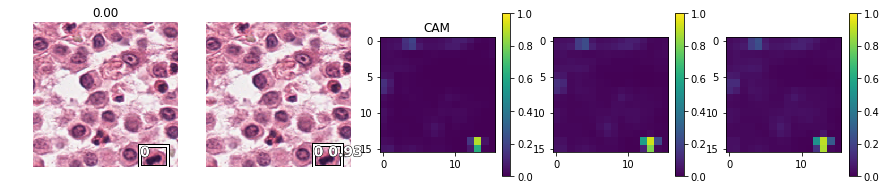

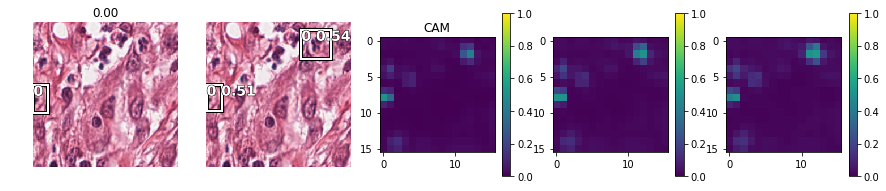

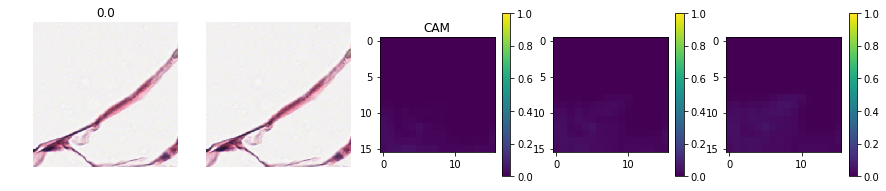

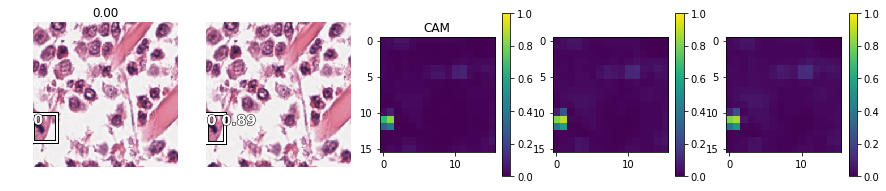

In [15]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [17]:
learn.export("RetinaNet-MEL-export.pth")